<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author - Patrick Seidel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp", "o3"]
TIMESERIES_DATA_DIR = "../time_series_forecasting/timeseries_data/"

In [2]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [3]:
from re import X
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("../content/X_train.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("../content/X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("../content/y_train.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("../content/y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Raw data csv is also made available for the select stations in URL:
# url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
# dataframe = pd.read_csv(url,parse_dates=["datetime"])
# Else if using local files:
dataframe = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}


# the station code is the first variable column, hence select only the last two
X_train = X_train_full[:,:,1:].copy()
X_test = X_test_full[:,:,1:].copy()

# for the label, we only want the ozone data, which is the second column
y_train = y_train_full[:,:,2].copy()
y_test = y_test_full[:,:,2].copy()

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# verify the shapes of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train_full shape: (69370, 336, 3), y_train_full shape: (69370, 96, 3)
X_test_full shape: (29730, 336, 3), y_test_full shape: (29730, 96, 3)
X_train shape: (69370, 336, 2), y_train shape: (69370, 96)
X_test shape: (29730, 336, 2), y_test shape: (29730, 96)


In [4]:
y_train_variables= y_train_full[:, :, 1:]
X_train = np.concatenate((X_train, y_train_variables), axis=1)  # concatenate the training data with the test data

# mask out the ozone data in the training set
X_train[:, context_window:, 1] = -1000
X_train = np.array(X_train, dtype=np.float32)

In [5]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_column)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_column)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/drive/folders/1svSuEHTDMrkL_CrHqYHgtp2ZuWOuFTXS?usp=drive_link
# and the path needs to be updated to checkpoint_dir below to local downloaded path:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, f"lstm_multivariate_future_temp.h5")
## Ignore user warning on keras as the choice for this exercise is to use h5.

if os.path.exists(checkpoint_path):
    print(f"Loading existing model")
    lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
else:
    print(f"Training new model")

    lstm_model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(context_window, len(variable_column))), # change to allow mulitple input variables
        LSTM(lstm_units, return_sequences=False),
        Dense(prediction_horizon)
    ])

    lstm_model.compile(optimizer="adam", loss="mse")

    checkpoint_callback = ModelCheckpoint(
        checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
    )

    training = lstm_model.fit(
        X_train,
        y_train,
        epochs=lstm_epochs, batch_size=lstm_batch_size,
        validation_split=0.2, verbose=1,
        callbacks=[checkpoint_callback]
    )

    training_history = training.history

Training new model
Epoch 1/5


/opt/homebrew/anaconda3/envs/mless/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3469/3469 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.7331
Epoch 1: val_loss improved from inf to 0.63486, saving model to ./checkpoint/lstm_multivariate_future_temp.h5


3469/3469 ━━━━━━━━━━━━━━━━━━━━ 404s 116ms/step - loss: 0.7330 - val_loss: 0.6349
Epoch 2/5
3469/3469 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.6283
Epoch 2: val_loss improved from 0.63486 to 0.61515, saving model to ./checkpoint/lstm_multivariate_future_temp.h5


3469/3469 ━━━━━━━━━━━━━━━━━━━━ 391s 113ms/step - loss: 0.6283 - val_loss: 0.6151
Epoch 3/5
3469/3469 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.5872
Epoch 3: val_loss did not improve from 0.61515
3469/3469 ━━━━━━━━━━━━━━━━━━━━ 387s 112ms/step - loss: 0.5872 - val_loss: 0.6327
Epoch 4/5
3469/3469 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.5880

In [ ]:

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

print(f"Predicting for ozone")

lstm_pred = lstm_model.predict(X_test)

lstm_pred = (
    lstm_pred * scaler_stats["o3"]['std'] + scaler_stats["o3"]['mean']
)
y_test_actual = (
    y_test * scaler_stats["o3"]['std'] + scaler_stats["o3"]['mean']
)

Predicting for ozone
930/930 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step


In [11]:
# Evaluate the model for this variable
evaluate_model(y_test_actual, lstm_pred)

RMSE: 0.6877


np.float64(0.6876520758254568)

In [12]:
X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
context=X_test_full[X_first_idx, :, 2] # for comparability, stick with given code, even though not necessary
# First sample of DENW094 station to compare with PatchTST

actual_future = y_test[X_first_idx, :]
predicted_future = lstm_pred[X_first_idx, :] #actual and pred denormalized in prev cell


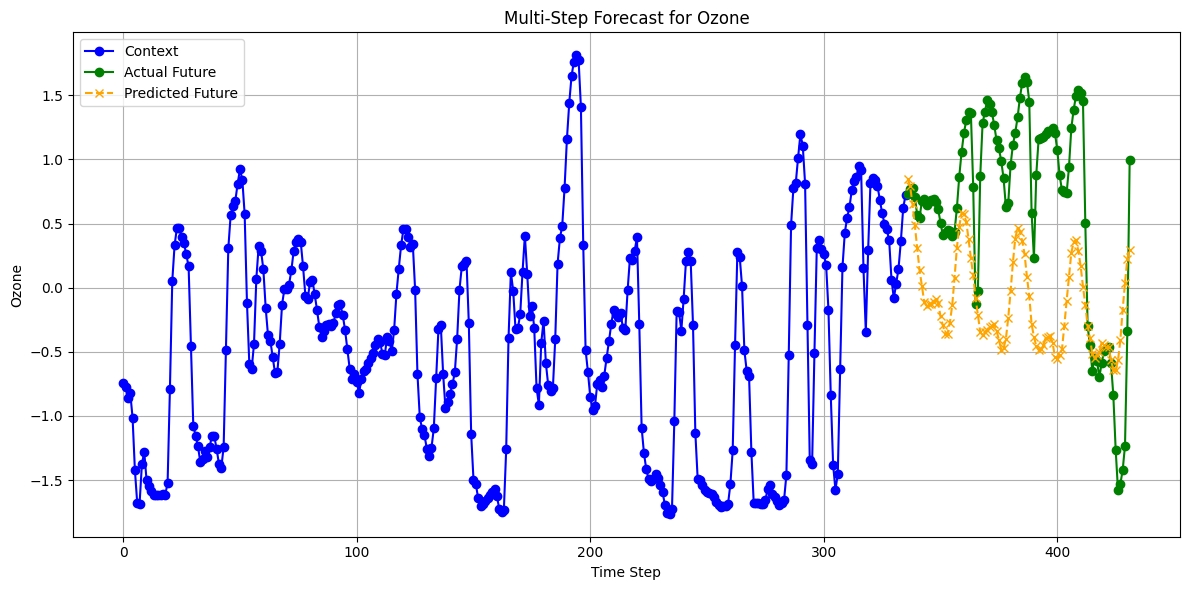

In [14]:
# Combine context and actual future to form full ground truth time series
ozone_timeseries = np.concatenate([context, actual_future])

# Set up plot
plt.figure(figsize=(12, 6))

# Time ranges
context_range = range(context_window)
future_range = range(context_window, context_window + prediction_horizon)

# Plot context
plt.plot(
    context_range,
    context,
    label="Context",
    color="blue",
    marker="o"
)

# Plot actual future
plt.plot(
    future_range,
    actual_future,
    label="Actual Future",
    color="green",
    marker="o"
)

# Plot predicted future
plt.plot(
    future_range,
    predicted_future,
    label="Predicted Future",
    color="orange",
    linestyle="--",
    marker="x"
)

# Labels and legend
plt.title("Multi-Step Forecast for Ozone")
plt.xlabel("Time Step")
plt.ylabel("Ozone")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
#write forecast values to csv
forecast_df = pd.DataFrame({
    'timepoints': range(context_window, context_window + prediction_horizon),
    'forecast': predicted_future
})

forecast_df.to_csv(f'LSTM_multivar_forecast.csv', index=False)

Done.